In [0]:
# !nvidia-smi

In [2]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 645kB 5.1MB/s 
     |████████████████████████████████| 3.8MB 23.9MB/s 
     |████████████████████████████████| 1.1MB 54.2MB/s 
     |████████████████████████████████| 890kB 55.7MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/155-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [7]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [22]:
database_base_path = COLAB_BASE_PATH + 'Data/aux/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_1.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_2.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_3.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_4.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_5.tar.gz'


# Unzip files (balanced)
os.mkdir('balanced/')
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/balanced/fold_1.tar.gz' -C 'balanced/'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/balanced/fold_2.tar.gz' -C 'balanced/'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/balanced/fold_3.tar.gz' -C 'balanced/'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/balanced/fold_4.tar.gz' -C 'balanced/'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/balanced/fold_5.tar.gz' -C 'balanced/'

,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_valid.npy
fold_1/x_valid_aux.npy
fold_1/y_train_mask.npy
fold_1/x_train_aux.npy
fold_1/x_valid.npy
fold_1/x_valid_aux2.npy
fold_1/y_valid_aux.npy
fold_1/y_train.npy
fold_1/y_train_aux.npy
fold_1/y_valid_mask.npy
fold_1/x_train.npy
fold_1/x_train_aux2.npy
fold_2/
fold_2/y_valid.npy
fold_2/x_valid_aux.npy
fold_2/y_train_mask.npy
fold_2/x_train_aux.npy
fold_2/x_valid.npy
fold_2/x_valid_aux2.npy
fold_2/y_valid_aux.npy
fold_2/y_train.npy
fold_2/y_train_aux.npy
fold_2/y_valid_mask.npy
fold_2/x_train.npy
fold_2/x_train_aux2.npy
fold_3/
fold_3/y_valid.npy
fold_3/x_valid_aux.npy
fold_3/y_train_mask.npy
fold_3/x_train_aux.npy
fold_3/x_valid.npy
fold_3/x_valid_aux2.npy
fold_3/y_valid_aux.npy
fold_3/y_train.npy
fold_3/y_train_aux.npy
fold_3/y_valid_mask.npy
fold_3/x_train.npy
fold_3/x_train_aux2.npy
fold_1/
fold_1/y_valid.npy
fold_1/x_valid_aux.npy
fold_1/y_train.npy
fold_1/x_train_aux2.npy
fold_1/x_train.npy
fold_1/y_train_aux.npy
fold_1/y_train_mask.npy
fold_1/x_train_aux.npy
fo

# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 4,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 4,
  "question_size": 4,
  "N_FOLDS": 3,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1e-06


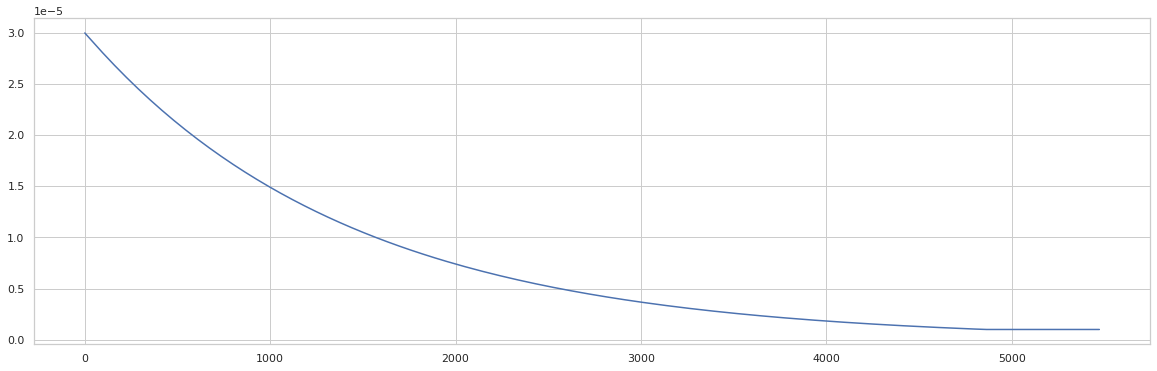

In [28]:
lr_min = 1e-6
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train']) *2
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
decay = .9993

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=1, lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    last_state = sequence_output[0]
    
    x_start = layers.Dropout(.1)(last_state) 
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dropout(.1)(last_state) 
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [36]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')

    # Load data (balanced)
    x_train = np.hstack([x_train, np.load('balanced/' + base_data_path + 'x_train.npy')])
    y_train = np.hstack([y_train, np.load('balanced/' + base_data_path + 'y_train.npy')]) 
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)

    # Build TF datasets (balanced)
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn(y['y_start'], probabilities[0])
                loss_end = loss_fn(y['y_end'], probabilities[1])
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn(y['y_start'], probabilities[0])
            loss_end = loss_fn(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=1, lr_start=lr_max, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))

    loss_fn = losses.categorical_crossentropy

    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         (MODEL_BASE_PATH + model_path), save_last=False)
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH +'last_' + model_path)
    
    # Make predictions
    x_train = np.load(base_data_path + 'x_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 1270 steps, validate for 171 steps

EPOCH 1/4
time: 485.9s loss: 2.0051 loss_start: 1.0159 loss_end: 0.9892 val_loss: 1.4899 val_loss_start: 0.7631 val_loss_end: 0.7268
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/155-roBERTa_base/model_fold_1.h5"

EPOCH 2/4
time: 475.7s loss: 1.5295 loss_start: 0.8014 loss_end: 0.7282 val_loss: 1.3670 val_loss_start: 0.7215 val_loss_end: 0.6455
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/155-roBERTa_base/model_fold_1.h5"

EPOCH 3/4
time: 477.3s loss: 1.3935 loss_start: 0.7355 loss_end: 0.6580 val_loss: 1.3341 val_loss_start: 0.6978 val_loss_end: 0.6363
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/155-roBERTa_base/model_fold_1.h5"

EPOCH 4/4
time: 477.3s loss: 1.3248 loss_start: 0.7016 loss_end: 0.6232 val_loss: 1.3438 val_loss_start: 0.6990 val_loss_end: 0.6

# Model loss graph

Fold: 1


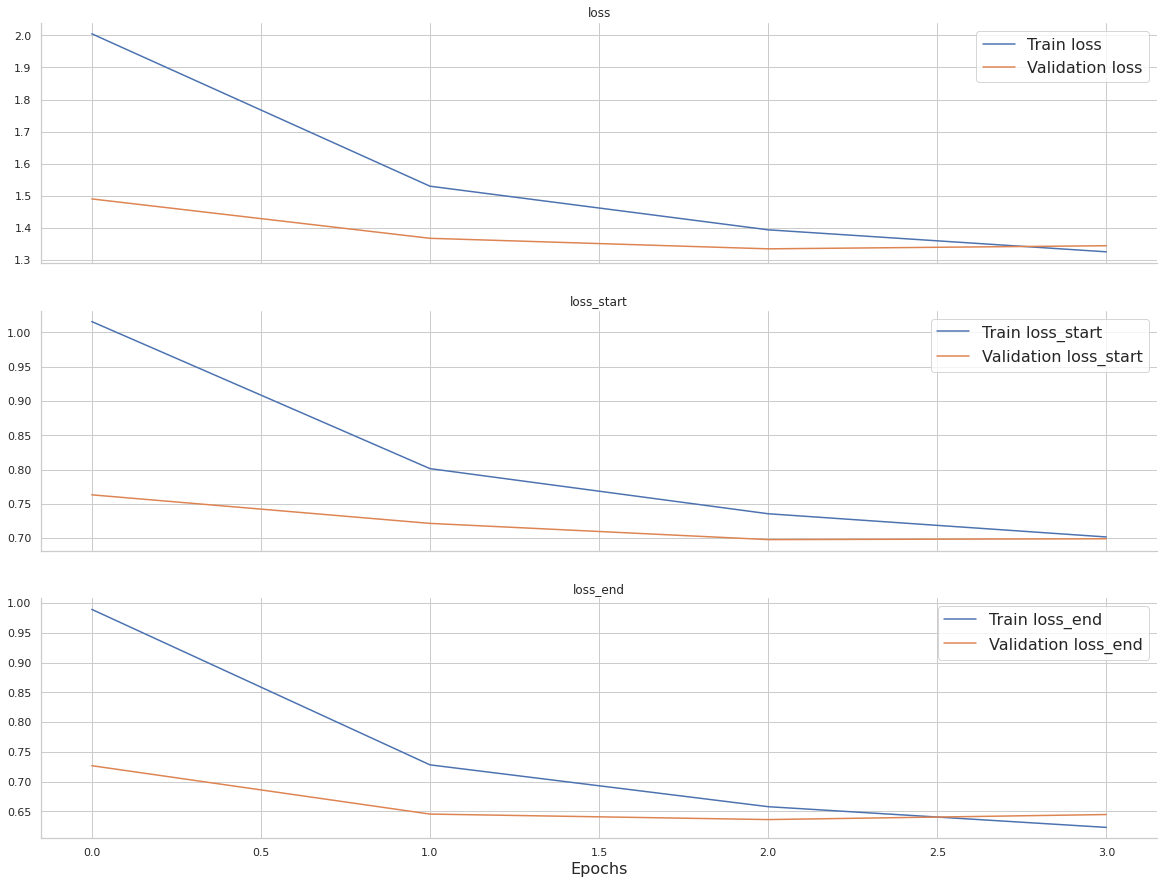

Fold: 2


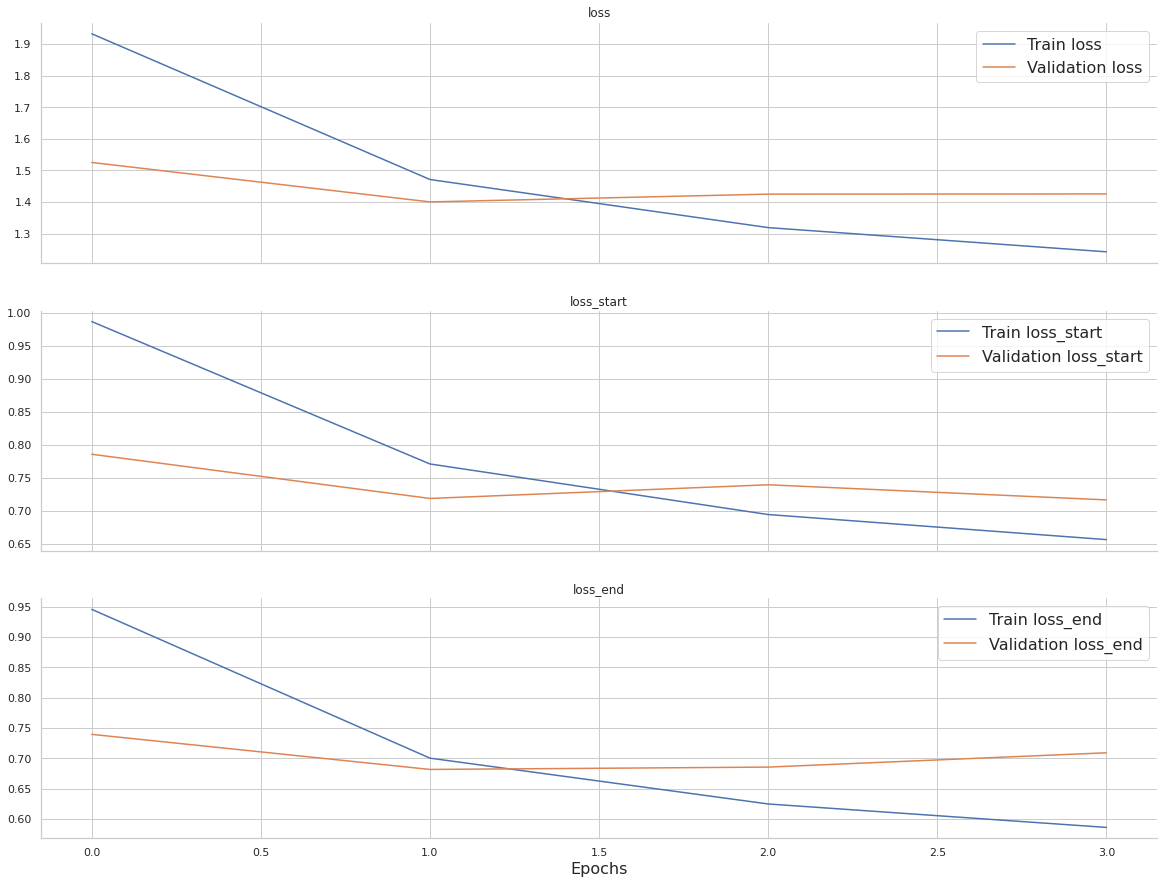

Fold: 3


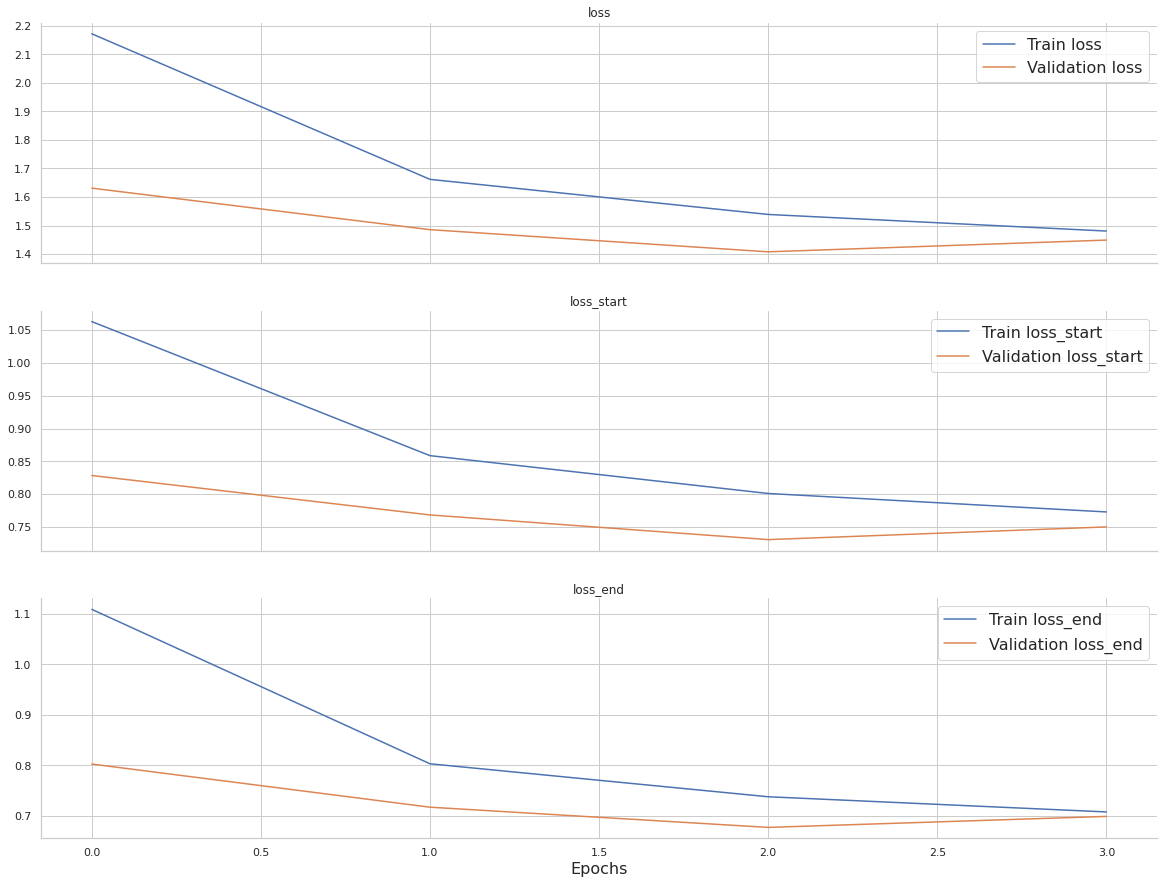

In [37]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [38]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric/Jaccard,,,,,,,,,
Overall,0.760306,0.728728,0.031578,0.766568,0.729314,0.777982,0.730463,0.736368,0.726409
Sentiment negative,0.625582,0.565449,0.060132,0.633578,0.560064,0.656984,0.575269,0.586184,0.561015
Sentiment neutral,0.975272,0.973982,0.001290,0.975502,0.974249,0.976143,0.973238,0.974171,0.974458
Sentiment positive,0.604006,0.559007,0.044999,0.616526,0.565337,0.631023,0.556542,0.564468,0.555142
0 <= text wordCnt < 3,0.865760,0.857145,0.008615,0.875291,0.817164,0.869369,0.869757,0.852619,0.884514
3 <= text wordCnt < 10,0.807495,0.782390,0.025105,0.814706,0.772341,0.822342,0.789888,0.785435,0.784939
10 <= text wordCnt < 30,0.731387,0.696540,0.034847,0.737435,0.702742,0.750970,0.694850,0.705756,0.692028
30 <= text wordCnt < 100,0.701425,0.618515,0.082910,0.691605,0.677052,0.730182,0.643409,0.682487,0.535085
0 <= selected text wordCnt < 3,0.698045,0.642290,0.055755,0.710297,0.642102,0.720731,0.646727,0.663106,0.638041


# Visualize predictions

In [39]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,0.166667,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,wow...,0.200000,wow...,0.200000,wow... u just became cooler.,1.000000
